In [ ]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, random, os
warnings.filterwarnings("ignore")

if not hasattr(np, "bool"): np.bool = np.bool_
if not hasattr(np, "int"):  np.int  = int

from typing import Tuple, Optional, List, Dict

import inspect

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, brier_score_loss
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from scipy.stats import spearmanr

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.isotonic import IsotonicRegression

_HAS_XGB = _HAS_LGBM = _HAS_CB = False
PRINTED_SHAP_FALLBACK = False

try:
    from xgboost import XGBClassifier
    _HAS_XGB = True
except Exception:
    pass

try:
    from lightgbm import LGBMClassifier
    _HAS_LGBM = True
except Exception:
    pass

try:
    from catboost import CatBoostClassifier
    _HAS_CB = True
except Exception:
    pass

try:
    from scipy.io import arff as _arff
except Exception:
    _arff = None

try:
    import shap
    _HAS_SHAP = True
except Exception:
    _HAS_SHAP = False

from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.neural_network import MLPClassifier

_KEYWORDS = ["defect", "bug", "fault", "class", "label", "target", "isdefect", "is_defect"]

def _fit_optional_weight(estimator, X, y, sample_weight=None, **kwargs):
    """
    Call estimator.fit, passing sample_weight only if it's supported.
    For safety, swallow signature/TypeErrors and retry without weights.
    """
    try:
        sig = inspect.signature(estimator.fit)
        if "sample_weight" in sig.parameters and sample_weight is not None:
            return estimator.fit(X, y, sample_weight=sample_weight, **kwargs)
        else:
            return estimator.fit(X, y, **kwargs)
    except (TypeError, ValueError):
        return estimator.fit(X, y, **kwargs)

def _class_balanced_weights(y: np.ndarray) -> np.ndarray:
    """Return per-sample weights proportional to inverse class frequency."""
    cls = np.unique(y)
    cw = compute_class_weight(class_weight='balanced', classes=cls, y=y)
    m = {c:w for c,w in zip(cls, cw)}
    return np.vectorize(m.get)(y)

def _fit_calibrator_isotonic(y_val: np.ndarray, p_val: np.ndarray):
    """Fit isotonic regression to map raw probs -> calibrated probs."""
    p_val = np.clip(p_val, 1e-6, 1-1e-6)
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(p_val, y_val.astype(float))
    return iso

def _tune_threshold(y_val: np.ndarray, p_val_cal: np.ndarray) -> float:
    """Pick threshold maximizing F1 on the small validation split."""
    grid = np.linspace(0.2, 0.8, 25)
    best_t, best_f1 = 0.5, -1.0
    for t in grid:
        pred = (p_val_cal >= t).astype(int)
        f1 = f1_score(y_val, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return float(best_t)

def _safe_decode_col(s: pd.Series) -> pd.Series:
    if s.dtype == object:
        try:
            return s.apply(lambda x: x.decode("utf-8") if isinstance(x, (bytes, bytearray)) else x)
        except Exception:
            return s
    return s

def _coerce_binary(series: pd.Series) -> pd.Series:
    """Coerce a variety of binary encodings into {0,1} ints."""
    s = series.copy()
    if pd.api.types.is_numeric_dtype(s):
        uniq = sorted(pd.unique(s.dropna()))
        if set(uniq).issubset({0,1}):
            return s.astype(int)
        if set(uniq).issubset({-1,1}):
            return ((s + 1) // 2).astype(int)  # -1->0, 1->1
        if len(uniq) == 2:
            m = {uniq[0]:0, uniq[1]:1}
            return s.map(m).astype(int)

    sval = s.astype(str).str.strip().str.lower()
    mapping = {
        "true":1, "false":0, "t":1, "f":0,
        "yes":1, "no":0, "y":1, "n":0,
        "defective":1, "non-defective":0, "nondefective":0, "clean":0, "faulty":1,
        "positive":1, "negative":0, "pos":1, "neg":0,
        "1":1, "0":0
    }
    mapped = sval.map(mapping)
    if not mapped.isna().all():
        if mapped.isna().any():
            u = list(pd.unique(sval))
            if len(u) == 2:
                m = {u[0]:0, u[1]:1}
                mapped = sval.map(m)
        if mapped.isna().any():
            raise ValueError("Could not fully coerce target to binary.")
        return mapped.astype(int)
    u = list(pd.unique(sval))
    if len(u) == 2:
        return sval.map({u[0]:0, u[1]:1}).astype(int)
    raise ValueError("Column is not binary or has unexpected labels.")

def _is_binary_col(s: pd.Series) -> bool:
    try:
        _ = _coerce_binary(s)
        return True
    except Exception:
        return False

def _score_target_candidate(colname: str, s: pd.Series, pos_index: int, total_cols: int) -> float:
    name = colname.lower()
    score = 0.0
    if any(k in name for k in _KEYWORDS): score += 2.0
    if pos_index == total_cols - 1:       score += 1.0
    if _is_binary_col(s):                 score += 2.0
    try:
        y = _coerce_binary(s)
        p = y.mean()
        if 0.05 <= p <= 0.95: score += 1.0
        else:                  score += 0.5
    except Exception:
        pass
    return score

def infer_target_and_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, str]:
    for c in df.columns:
        df[c] = _safe_decode_col(df[c])

    cols = list(df.columns)
    scores = []
    for i, c in enumerate(cols):
        s = df[c]
        scores.append((_score_target_candidate(c, s, i, len(cols)), i, c))
    scores.sort(reverse=True)

    for _, idx, cname in scores:
        s = df[cname]
        if _is_binary_col(s):
            try:
                y = _coerce_binary(s)
                X = df.drop(columns=[cname]).copy()
                print(f"[Target] Auto-detected column: '{cname}' (pos {idx+1}/{len(cols)})")
                return X, y.astype(int), cname
            except Exception:
                continue

    last = cols[-1]
    if _is_binary_col(df[last]):
        y = _coerce_binary(df[last])
        X = df.iloc[:, :-1].copy()
        print(f"[Target] Fallback to last column: '{last}'")
        return X, y.astype(int), last

    for c in cols:
        if df[c].nunique(dropna=True) == 2:
            y = _coerce_binary(df[c])
            X = df.drop(columns=[c]).copy()
            print(f"[Target] Fallback to 2-unique column: '{c}'")
            return X, y.astype(int), c

    raise ValueError("Could not automatically infer a binary target column.")


def load_dataset_auto(data_path: str) -> pd.DataFrame:
    ext = os.path.splitext(data_path)[1].lower()
    if ext == ".csv":
        return pd.read_csv(data_path)
    elif ext == ".arff":
        if _arff is None:
            raise ImportError("scipy is required for reading .arff files (scipy.io.arff).")
        data, meta = _arff.loadarff(data_path)
        df = pd.DataFrame(data)
        for c in df.columns:
            df[c] = _safe_decode_col(df[c])
        for c in df.columns:
            if df[c].dtype == object:
                try:
                    df[c] = pd.to_numeric(df[c])
                except Exception:
                    pass
        return df
    else:
        raise ValueError(f"Unsupported file extension: {ext}. Use .csv or .arff")

def load_and_preprocess(data_path: str) -> Tuple[pd.DataFrame, pd.Series, str]:
    df = load_dataset_auto(data_path)
    X, y, tgt = infer_target_and_features(df)

    const_cols = [c for c in X.columns if X[c].nunique(dropna=False) <= 1]
    if const_cols:
        print("Dropping constant columns:", const_cols)
        X.drop(columns=const_cols, inplace=True)

    if X.isna().sum().any():
        print("Missing values detected; forward/back fill.")
        X = X.fillna(method="ffill").fillna(method="bfill")
    else:
        print("No missing values detected.")

    for c in X.columns:
        if X[c].dtype == object:
            try: X[c] = pd.to_numeric(X[c])
            except Exception: pass

    return X, y.astype(int), tgt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier

def make_model(name: str, random_state: int):
    n = name.strip().lower()
    if n in ("random_forest","rf"):
        return RandomForestClassifier(
            n_estimators=600, max_depth=None, min_samples_leaf=2,
            random_state=random_state, n_jobs=-1, class_weight="balanced_subsample", oob_score=False
        )
    if n in ("extra_trees","extratrees","et"):
        return ExtraTreesClassifier(
            n_estimators=800, max_depth=None, min_samples_leaf=1,
            random_state=random_state, n_jobs=-1, class_weight="balanced_subsample"
        )
    if n in ("gradient_boosting","gbrt","gb"):
        return GradientBoostingClassifier(
            random_state=random_state, learning_rate=0.05, n_estimators=800, max_depth=3
        )
    if n in ("adaboost","ada"):
        base = DecisionTreeClassifier(max_depth=2, random_state=random_state)
        params = dict(n_estimators=800, learning_rate=0.05, random_state=random_state)
        try:
            return AdaBoostClassifier(estimator=base, **params)     # newer sklearn
        except TypeError:
            return AdaBoostClassifier(base_estimator=base, **params) # older sklearn
    if n in ("xgboost","xgb"):
        if not _HAS_XGB:
            print("[WARN] xgboost not installed; falling back to RandomForest.")
            return make_model("rf", random_state)
        return XGBClassifier(
            n_estimators=1200, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0,
            eval_metric="logloss", tree_method="hist", random_state=random_state, n_jobs=-1
        )
    if n in ("lightgbm","lgbm","lgb"):
        if not _HAS_LGBM:
            print("[WARN] lightgbm not installed; falling back to RandomForest.")
            return make_model("rf", random_state)
        return LGBMClassifier(
            n_estimators=1500, num_leaves=31, learning_rate=0.03,
            subsample=0.8, colsample_bytree=0.8, random_state=random_state, n_jobs=-1
        )
    if n in ("catboost","cb"):
        if not _HAS_CB:
            print("[WARN] catboost not installed; falling back to RandomForest.")
            return make_model("rf", random_state)
        return CatBoostClassifier(
            iterations=1200, depth=6, learning_rate=0.05,
            verbose=False, random_seed=random_state, loss_function="Logloss"
        )
    if n in ("mlp","nn","pytorch_mlp"):
        return MLPClassifier(
            hidden_layer_sizes=(256,128,64), activation="relu", solver="adam",
            alpha=3e-4, learning_rate_init=1e-3, max_iter=400,
            batch_size='auto', early_stopping=True, n_iter_no_change=20,
            random_state=random_state
        )
    raise ValueError(f"Unknown model name: {name}")

def is_tree_model(model) -> bool:
    return any(k in model.__class__.__name__.lower() for k in
               ["forest","tree","boost","xgb","lgbm","catboost","gradientboost","extratrees"])

def spearman_rank_corr(a: pd.Series, b: pd.Series) -> float:
    a, b = a.align(b, join='inner')
    av, bv = a.values, b.values
    if np.nanstd(av) == 0 and np.nanstd(bv) == 0: return 1.0
    if np.nanstd(av) == 0 or np.nanstd(bv) == 0:  return 0.0
    return spearmanr(pd.Series(av).rank(), pd.Series(bv).rank(), nan_policy='omit').correlation

def bce_loss(p, y):
    p = np.clip(p, 1e-8, 1-1e-8)
    return -(y*np.log(p) + (1-y)*np.log(1-p))

def finite_diff_grad_loss(model, X_eval: np.ndarray, y_eval: np.ndarray, eps_vec: np.ndarray):
    n, d = X_eval.shape
    grads = np.zeros((n, d), dtype=float)
    for j in range(d):
        e = np.zeros_like(X_eval); e[:, j] = eps_vec[j]
        pp = model.predict_proba(X_eval + e)[:, 1]
        pm = model.predict_proba(X_eval - e)[:, 1]
        grads[:, j] = (bce_loss(pp, y_eval) - bce_loss(pm, y_eval)) / (2.0 * eps_vec[j] + 1e-12)
    return np.abs(grads)

def normalize_rows(A: np.ndarray, eps=1e-12):
    s = A.sum(axis=1, keepdims=True) + eps
    return A / s

def expected_calibration_error(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)
    bins = np.linspace(0.0, 1.0, n_bins+1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0
    for b in range(n_bins):
        mask = inds == b
        if not np.any(mask): 
            continue
        conf = y_prob[mask].mean()
        acc = y_true[mask].mean()
        ece += (np.sum(mask) / len(y_true)) * np.abs(acc - conf)
    return ece

def rescale01_rho(rho):
    return (rho + 1.0) / 2.0 if not np.isnan(rho) else np.nan

def _shap_to_posclass_2d(sv):
    if isinstance(sv, list):
        return sv[1] if len(sv) > 1 else sv[0]
    sv = np.asarray(sv)
    if sv.ndim == 3:
        return sv[..., 1] if sv.shape[-1] >= 2 else sv.mean(axis=-1)
    return sv

def global_importance(model, X_train: pd.DataFrame, X_eval: pd.DataFrame, y_eval: Optional[pd.Series] = None):
    feature_names = X_eval.columns

    from sklearn.ensemble import AdaBoostClassifier
    if isinstance(model, AdaBoostClassifier) and hasattr(model, "feature_importances_"):
        imp = np.abs(np.asarray(model.feature_importances_, dtype=float))
        imp_s = pd.Series(imp, index=feature_names, name="mean|FI|")
        sv_abs = np.tile(imp, (len(X_eval), 1))
        return imp_s, sv_abs

    def _is_supported_tree(m):
        name = m.__class__.__name__.lower()
        return any(k in name for k in ["randomforest", "extratrees", "gradientboost", "xgb", "lgbm", "catboost"])

    if _HAS_SHAP:
        try:
            bg = shap.sample(X_train, min(256, len(X_train)))
            if _is_supported_tree(model):
                explainer = shap.TreeExplainer(
                    model, data=bg, feature_perturbation="interventional", model_output="probability"
                )
                sv = explainer.shap_values(X_eval, check_additivity=False)
                sv = _shap_to_posclass_2d(sv)
                sv_abs = np.abs(np.asarray(sv))
                return pd.Series(sv_abs.mean(axis=0), index=feature_names, name="mean|SHAP|"), sv_abs
            raise RuntimeError("Use permutation importance for non-tree models.")
        except Exception:
            global PRINTED_SHAP_FALLBACK
            if not PRINTED_SHAP_FALLBACK:
                print("[SHAP] Falling back to permutation importance for unsupported model.")
                PRINTED_SHAP_FALLBACK = True

    if y_eval is None:
        y_for_perm = (model.predict_proba(X_eval)[:, 1] >= 0.5).astype(int)
        scoring = "neg_brier_score"
    else:
        y_for_perm = y_eval
        scoring = "roc_auc"

    pi = permutation_importance(
        model,
        X_eval,
        y_for_perm,
        scoring=scoring,
        n_repeats=8,
        random_state=42,
        n_jobs=-1,
    )
    imp = np.abs(pi.importances_mean)
    imp_s = pd.Series(imp, index=feature_names, name="mean|PermImp|")
    sv_abs = np.tile(imp, (len(X_eval), 1))
    return imp_s, sv_abs

def safe_smote(Xtr: pd.DataFrame, ytr: pd.Series, random_state: int):
    try:
        minority = int((ytr == 1).sum())
        k = min(5, max(1, minority - 1))
        return SMOTE(random_state=random_state, k_neighbors=k).fit_resample(Xtr, ytr)
    except Exception as e:
        print(f"[SMOTE] skipped: {e}")
        return Xtr, ytr

def evaluate_fold(model, Xtr_fit, ytr_fit, Xte: pd.DataFrame, yte: pd.Series,
                  model_name: str, fold_seed: int):
    name = model_name.strip().lower()

    scaler = None
    Xtr_use, Xte_use = Xtr_fit, Xte
    sample_weight = None

    if name in ("mlp","nn","pytorch_mlp"):
        scaler = StandardScaler().fit(Xtr_fit.values.astype(float))
        Xtr_use = pd.DataFrame(scaler.transform(Xtr_fit.values.astype(float)), columns=Xtr_fit.columns, index=Xtr_fit.index)
        Xte_use = pd.DataFrame(scaler.transform(Xte.values.astype(float)),      columns=Xte.columns,      index=Xte.index)
        sample_weight = _class_balanced_weights(ytr_fit.values.astype(int))

    _fit_optional_weight(model, Xtr_use, ytr_fit, sample_weight=sample_weight)

    proba_raw_te = model.predict_proba(Xte_use)[:, 1]

    use_calibration = name in ("mlp","nn","pytorch_mlp","adaboost","ada")
    thresh = 0.5
    proba_cal_te = proba_raw_te

    if use_calibration:
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=fold_seed)
        (i_tr, i_val), = sss.split(Xtr_use, ytr_fit)

        Xtr_inner, ytr_inner = Xtr_use.iloc[i_tr], ytr_fit.iloc[i_tr]
        Xval,      yval      = Xtr_use.iloc[i_val], ytr_fit.iloc[i_val]

        m2 = make_model(model_name, random_state=fold_seed + 999)

        sw_inner = None
        if sample_weight is not None:
            sw_inner = _class_balanced_weights(ytr_inner.values.astype(int))

        _fit_optional_weight(m2, Xtr_inner, ytr_inner, sample_weight=sw_inner)


        p_val_raw = m2.predict_proba(Xval)[:, 1]

        iso = _fit_calibrator_isotonic(yval.values.astype(int), p_val_raw)

        proba_cal_te = iso.predict(np.clip(proba_raw_te, 1e-6, 1-1e-6))

        p_val_cal = iso.predict(np.clip(p_val_raw, 1e-6, 1-1e-6))
        thresh = _tune_threshold(yval.values.astype(int), p_val_cal)

    pred  = (proba_cal_te >= thresh).astype(int)

    metrics = {
        "AUC": roc_auc_score(yte, proba_cal_te),
        "F1":  f1_score(yte, pred, zero_division=0),
        "Precision": precision_score(yte, pred, zero_division=0),
        "Recall":    recall_score(yte, pred),
        "Brier":     brier_score_loss(yte, proba_cal_te),
        "thr":       thresh,
    }
    return proba_cal_te, metrics, (scaler, Xtr_use, Xte_use)

def glr_rhos_for_fold(shap_abs_test: np.ndarray, grad_norm: np.ndarray, feature_names):
    n = shap_abs_test.shape[0]
    rhos = []
    for i in range(n):
        s = pd.Series(shap_abs_test[i, :], index=feature_names)
        g = pd.Series(grad_norm[i, :],      index=feature_names)
        rhos.append(float(spearman_rank_corr(s, g)))
    return rhos

def epsilon_hitk_for_subset(model, Xte_np, yte_np, shap_abs_test, top_k, eps, m_limit, chosen_idx):
    hits = []
    d = Xte_np.shape[1]
    proba = model.predict_proba(Xte_np)[:, 1]
    base_loss = bce_loss(proba, yte_np)

    for i in chosen_idx:
        x = Xte_np[i, :]; y_i = yte_np[i]
        shap_vec = shap_abs_test[i, :]
        M = min(m_limit, d)
        cand_idx = np.argsort(-shap_vec)[:M]
        topk_shap_idx = cand_idx[:top_k]

        X_batch = np.tile(x, (M, 1))
        X_batch[np.arange(M), cand_idx] += eps
        p_pert = model.predict_proba(X_batch)[:, 1]
        dL = bce_loss(p_pert, np.full(M, y_i)) - base_loss[i]
        topk_delta_idx = cand_idx[np.argsort(-dL)[:top_k]]

        hits.append(int(len(set(topk_shap_idx).intersection(set(topk_delta_idx))) > 0))
    return hits

def plot_top_features(global_mean_import_accum, topn=10, title_suffix="SHAP/Importance"):
    if not global_mean_import_accum:
        return
    imp_df = pd.concat(global_mean_import_accum, axis=1)
    imp_mean = imp_df.mean(axis=1).sort_values(ascending=False)
    N = min(topn, len(imp_mean))
    topN = imp_mean.head(N)[::-1]
    plt.figure(figsize=(8, max(4, N*0.5)))
    plt.barh(topN.index, topN.values)
    plt.xlabel("mean(|importance|) across folds (test)")
    plt.ylabel("Feature")
    plt.title(f"Top {N} Features by Importance (Test, mean across folds) — {title_suffix}")
    plt.tight_layout()
    plt.show()


def run_pipeline(
    data_path: str,
    model_name: str = "random_forest",
    n_splits: int = 5,
    rng: int = 42,
    top_k: int = 10,
    eps: float = 1e-3,
    calib_bins: int = 10,
    m_limit: int = 20,
    max_eps_samples: int = 50,
    plot: bool = True,
):
    np.random.seed(rng); random.seed(rng)

    X, y, tgt = load_and_preprocess(data_path)
    feature_names = X.columns.tolist()
    d = len(feature_names)
    eps_vec = np.full(d, eps, dtype=float)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rng)
    per_fold_metrics = []
    all_proba, all_y = [], []
    all_glr_rhos = []
    hitk_flags = []
    global_mean_import_accum = []
    eps_samples_used = 0

    for fold, (tr, te) in enumerate(skf.split(X, y), 1):
        Xtr, Xte = X.iloc[tr].copy(), X.iloc[te].copy()
        ytr, yte = y.iloc[tr].copy(), y.iloc[te].copy()

        Xtr_fit, ytr_fit = safe_smote(Xtr, ytr, random_state=fold)
        model = make_model(model_name, random_state=fold)

        proba, metrics, (_scaler, Xtr_used, Xte_used) = evaluate_fold(
            model, Xtr_fit, ytr_fit, Xte, yte, model_name=model_name, fold_seed=rng + fold
        )
        per_fold_metrics.append({"fold": fold, **metrics})
        all_proba.append(proba); all_y.append(yte.values)

        g_test_series, shap_abs_test = global_importance(model,
                                                         Xtr_used,  
                                                         Xte_used,  
                                                         yte)
        global_mean_import_accum.append(g_test_series)

        Xte_np = Xte_used.values.astype(float)
        yte_np = yte.values.astype(int)

        grad_abs  = finite_diff_grad_loss(model, Xte_np, yte_np, eps_vec)
        grad_norm = normalize_rows(grad_abs)

        all_glr_rhos.extend(glr_rhos_for_fold(shap_abs_test, grad_norm, feature_names))

        if eps_samples_used < max_eps_samples:
            idxs = np.arange(len(Xte_np)); np.random.shuffle(idxs)
            take = min(max_eps_samples - eps_samples_used, max(1, len(idxs)//6))
            chosen = idxs[:take]
            hitk_flags.extend(
                epsilon_hitk_for_subset(model, Xte_np, yte_np, shap_abs_test, top_k, eps, m_limit, chosen)
            )
            eps_samples_used += take
            
    per_fold_df = pd.DataFrame(per_fold_metrics)
    AUC_mean   = float(per_fold_df["AUC"].mean())
    F1_mean    = float(per_fold_df["F1"].mean())
    P_mean     = float(per_fold_df["Precision"].mean())
    R_mean     = float(per_fold_df["Recall"].mean())
    Brier_mean = float(per_fold_df["Brier"].mean())

    GLR_mean = float(np.nanmean(all_glr_rhos)) if len(all_glr_rhos) else np.nan
    Hitk     = float(np.mean(hitk_flags))      if len(hitk_flags)  else np.nan

    all_proba = np.concatenate(all_proba, axis=0)
    all_y     = np.concatenate(all_y, axis=0)
    ECE       = float(expected_calibration_error(all_y, all_proba, n_bins=calib_bins))

    ReliabilityScore = np.nanmean([rescale01_rho(GLR_mean), Hitk, max(0.0, 1.0 - ECE)])

    summary = pd.DataFrame([{
        "Model": model_name,
        "Detected_Target": tgt,
        "AUC_mean": AUC_mean, "F1_mean": F1_mean, "Precision_mean": P_mean, "Recall_mean": R_mean,
        "Brier_mean": Brier_mean, 
        "GLR_mean": GLR_mean, f"Hit@{top_k}": Hitk,
        "ECE": ECE, "ReliabilityScore": ReliabilityScore, "eps_samples_used": eps_samples_used
    }]).round(4)

    if plot:
        title_suffix = "TreeSHAP" if _HAS_SHAP else "Permutation"
        plot_top_features(global_mean_import_accum, topn=10, title_suffix=title_suffix)

    artifacts = {
        "per_fold_metrics": per_fold_df,
        "glr_rhos": np.array(all_glr_rhos, dtype=float),
        "all_proba": all_proba,
        "all_y": all_y,
        "top_importance_mean_test": (pd.concat(global_mean_import_accum, axis=1).mean(axis=1)
                                     if len(global_mean_import_accum) else pd.Series(dtype=float))
    }
    return summary, artifacts

[Target] Auto-detected column: 'Defective' (pos 36/36)
No missing values detected.


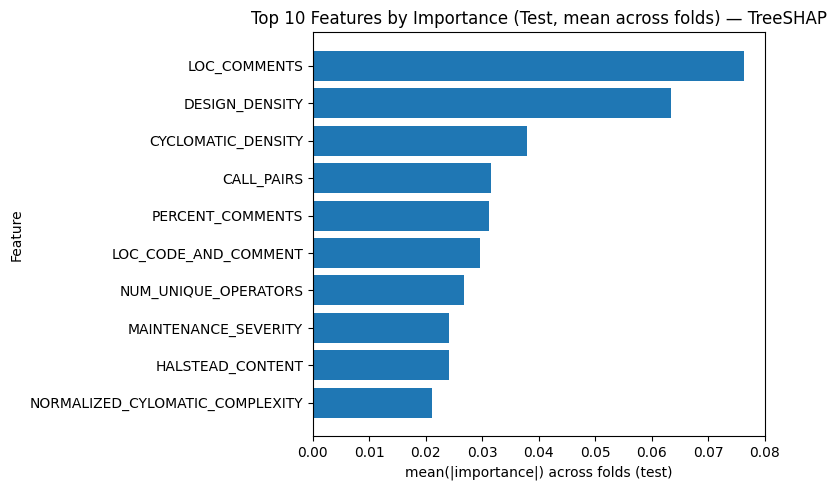

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,Defective,0.7226,0.1835,0.2253,0.1944,0.1477,0.1614,1.0,0.1359,0.8149,50


In [2]:
summary_cm1, arts_cm1 = run_pipeline("./../../dataset/CM1.csv", model_name="catboost")
summary_cm1

[Target] Auto-detected column: 'c' (pos 39/39)
No missing values detected.


100%|===================| 1889/1893 [01:25<00:00]        

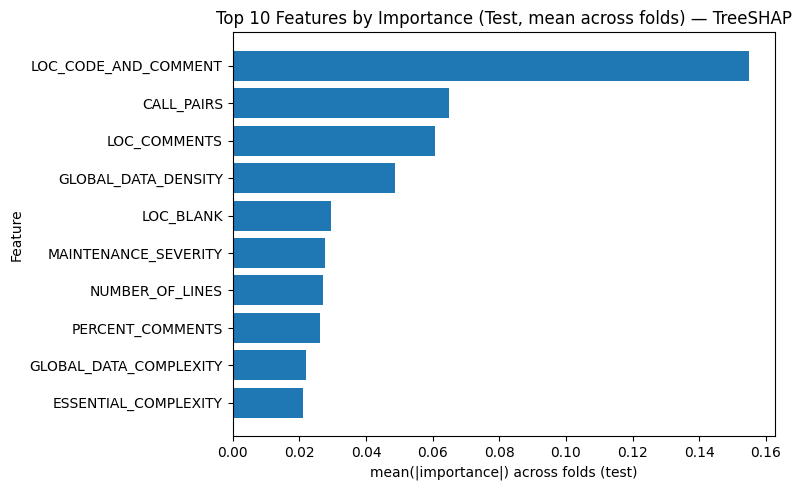

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,c,0.9738,0.4935,0.4715,0.533,0.006,0.2547,1.0,0.0046,0.8743,50


In [3]:
summary_mc1, arts_mc1 = run_pipeline("./../../dataset/mc1.arff", model_name="catboost")
summary_mc1

[Target] Auto-detected column: 'c' (pos 40/40)
No missing values detected.


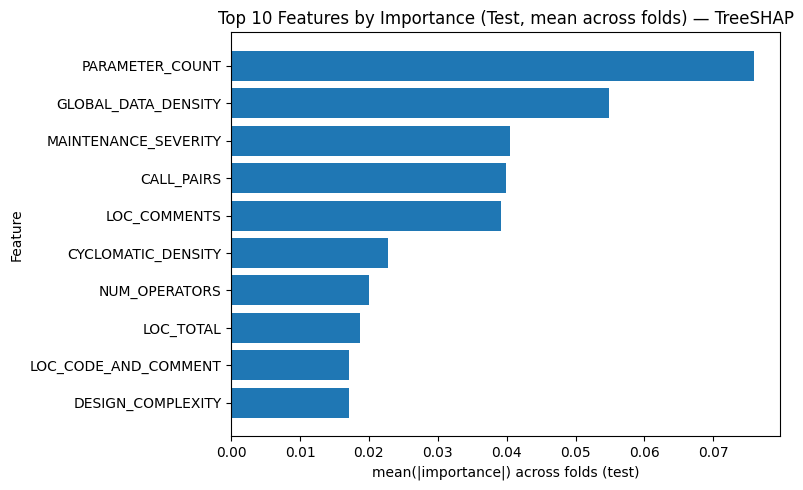

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,c,0.7765,0.5182,0.5797,0.4818,0.2117,-0.007,1.0,0.1795,0.7723,25


In [4]:
summary_mc2, arts_mc2 = run_pipeline("./../../dataset/mc2.arff", model_name="catboost")
summary_mc2

[Target] Auto-detected column: 'c' (pos 38/38)
No missing values detected.


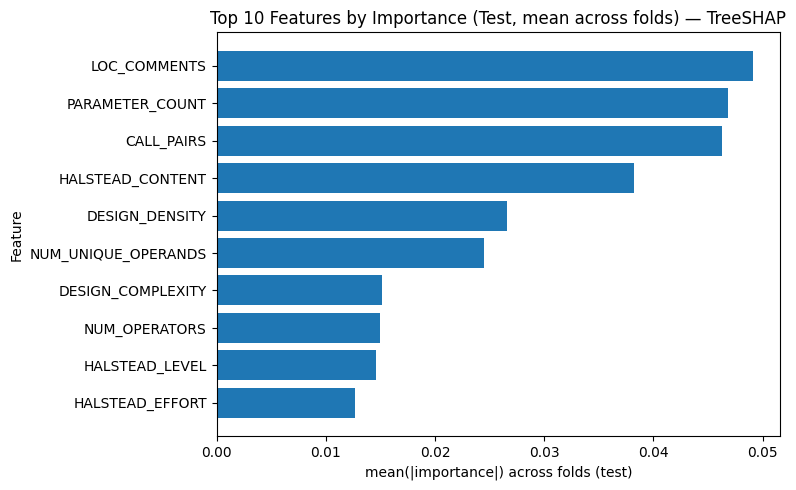

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,c,0.7785,0.2981,0.3267,0.2905,0.0859,0.0503,1.0,0.0827,0.8142,50


In [5]:
summary_mw1, arts_mw1 = run_pipeline("./../../dataset/mw1.arff", model_name="catboost")
summary_mw1

[Target] Auto-detected column: 'defects' (pos 22/22)
No missing values detected.


 98%|===================| 216/221 [00:11<00:00]        

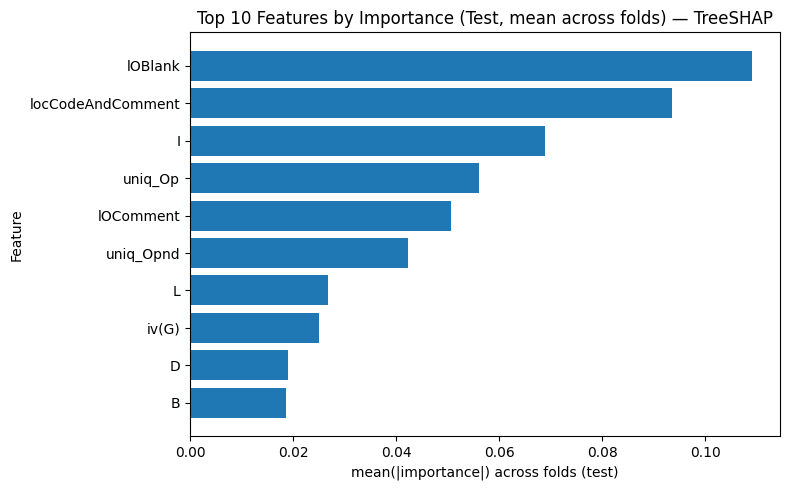

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,defects,0.8611,0.3608,0.3921,0.3917,0.0712,0.0704,1.0,0.0638,0.8238,50


In [6]:
summary_pc1, arts_pc1 = run_pipeline("./../../dataset/pc1.arff", model_name="catboost")
summary_pc1

[Target] Auto-detected column: 'c' (pos 37/37)
No missing values detected.


 99%|===================| 1111/1117 [00:45<00:00]        

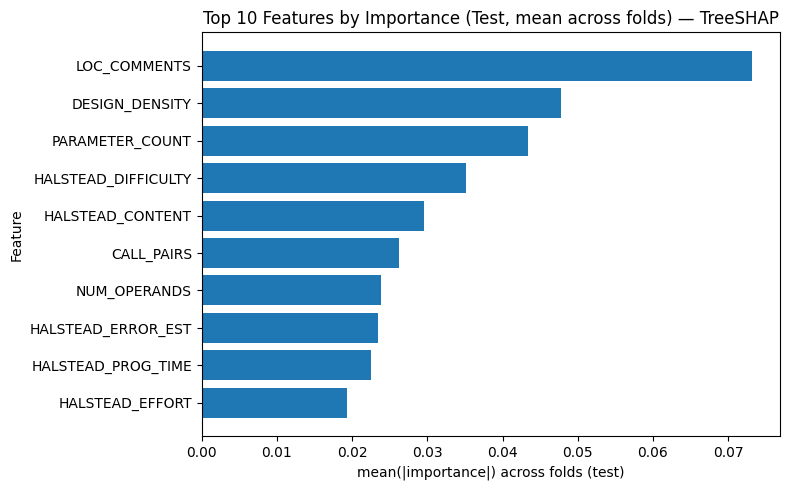

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,c,0.802,0.08,0.08,0.08,0.0064,0.2414,1.0,0.0052,0.8718,50


In [7]:
summary_pc2, arts_pc2 = run_pipeline("./../../dataset/pc2.arff", model_name="catboost")
summary_pc2

[Target] Auto-detected column: 'c' (pos 38/38)
No missing values detected.


 95%|=================== | 296/312 [00:16<00:00]       

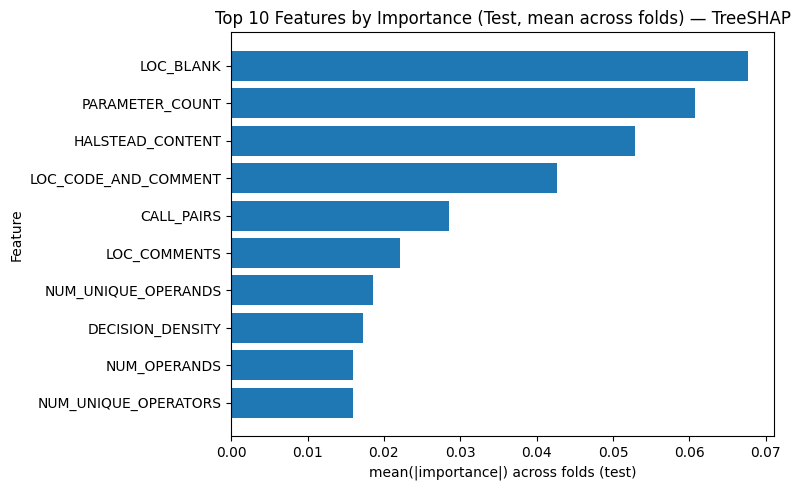

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,c,0.8309,0.4214,0.4776,0.3812,0.0891,0.0894,1.0,0.0698,0.825,50


In [8]:
summary_pc3, arts_pc3 = run_pipeline("./../../dataset/pc3.arff", model_name="catboost")
summary_pc3

[Target] Auto-detected column: 'c' (pos 38/38)
No missing values detected.


 95%|=================== | 276/291 [00:17<00:00]       

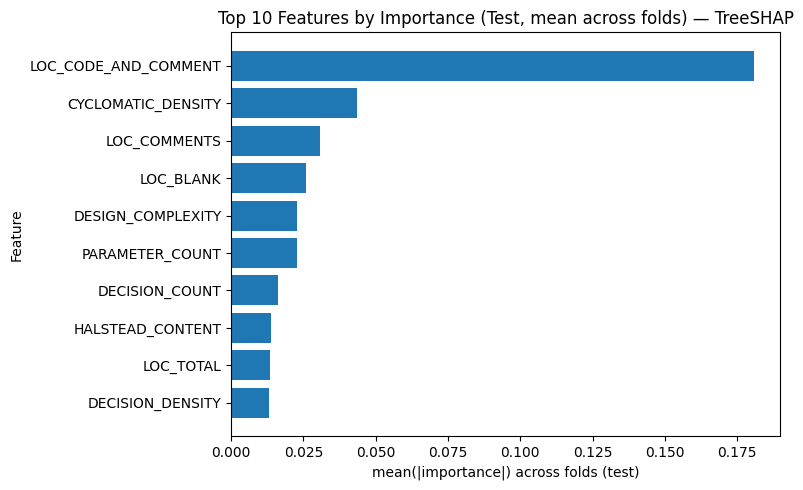

,Model,Detected_Target,AUC_mean,F1_mean,Precision_mean,Recall_mean,Brier_mean,GLR_mean,Hit@10,ECE,ReliabilityScore,eps_samples_used
0,catboost,c,0.949,0.6551,0.6195,0.696,0.0668,0.0647,1.0,0.0477,0.8282,50


In [9]:
summary_pc4, arts_pc4 = run_pipeline("./../../dataset/pc4.arff", model_name="catboost")
summary_pc4